In [2]:
# CUMULATIVE DISTRIBUTION FUNCTION

# import the libraries and data 
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os
os.chdir(os.path.join('data'))
df = pd.read_csv(r'2002FemPreg.csv',low_memory=False)
df = df[['caseid','prglngth','outcome','pregordr','birthord','totalwgt_lb','agepreg','finalwgt']]
df_live = df[df['outcome']==1]
# removing null values
df = df_live[df_live['totalwgt_lb'].notnull()]

In [3]:
# divide the dataframe into first babies and others
df_first_baby = df[df['birthord']==1]
df_other_babies = df[df['birthord']!=1]

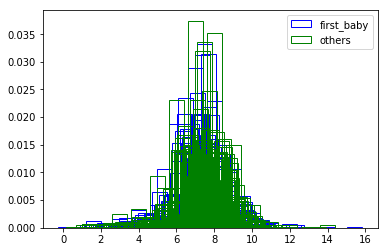

In [4]:
def calc_pmf(key,df):
    freq = df[key].value_counts().sort_index()
    freq_sum = sum(freq)
    pmf = freq/freq_sum
    return pmf.index,pmf.values

x,y = calc_pmf('totalwgt_lb',df_first_baby)
x1,y1 = calc_pmf('totalwgt_lb',df_other_babies)
fig,ax = plt.subplots()
ax.bar(x,y,facecolor='None',edgecolor='blue',label='first_baby')
ax.bar(x1,y1,facecolor='None',edgecolor='green',label='others')
ax.legend()
# PMFs work well if the number of values is small. But as the number of
# values increases, the probability associated with each value gets smaller and
# the effect of random noise increases.

But parts of this figure are hard to interpret. There are many spikes and
valleys, and some apparent differences between the distributions. It is hard
to tell which of these features are meaningful. Also, it is hard to see overall
patterns; for example, which distribution do you think has the higher mean?

These problems can be mitigated by binning the data; that is, dividing the
range of values into non-overlapping intervals and counting the number of
values in each bin. 
Binning can be useful, but it is tricky to get the size of
the bins right. 
If they are big enough to smooth out noise, they might also
smooth out useful information. 
An alternative to this is CDF - cumulative distribution function

In [5]:
scores = [55,66,77,88,99]
def percentile(scores,score):
    scores = sorted(scores)
    if score in scores:
        return (scores.index(score)+1)/len(scores)
    return NaN

In [6]:
percentile(scores,55)

0.2

In [7]:
# given percentile value find the marks
def nearest_percentile(percentile,scores):
    scores = sorted(scores)
    percentiles = [(i+1)/len(scores) for i in range(len(scores))]
    scope = [s for s in scores if s < percentile]
    return (scores.index(scope[-1])+1)/len(scores)
    

In [8]:
nearest_percentile(89,scores)

0.8

PercentileRank takes a value and computes its percentile rank in a set of
values; Percentile takes a percentile rank and computes the corresponding
value.

CUMULATIVE DENSITY FUNCTION
-----------------------------
The CDF is the function that maps from a value to its percentile rank.
The CDF is a function of x, where x is any value that might appear in the
distribution. To evaluate CDF(x) for a particular value of x, we compute
the fraction of values in the distribution less than or equal to x.

In [9]:
# count the fraction of values less than a particular values

def eval_cdf(value,series):
    count =0
    for x in series:
        if x <= value:
            count += 1
    return count/len(series)

values = [1,2,2,3,5]
query = [1,2,3,4,5]
for v in query:
    print('cdf('+str(v)+')',' = ',eval_cdf(v,values))

cdf(1)  =  0.2
cdf(2)  =  0.6
cdf(3)  =  0.8
cdf(4)  =  0.8
cdf(5)  =  1.0


We can evaluate the CDF for any value of x, not just values that appear in
the sample. If x is less than the smallest value in the sample, CDF(x) is 0.

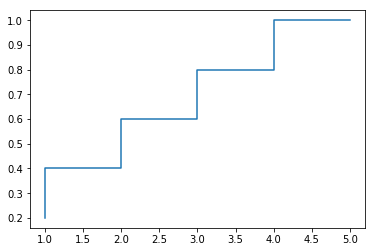

In [10]:
plt.step(query, [eval_cdf(y,query) for y in query])

In [11]:
df['prglngth'].values

array([39, 39, 39, ..., 39, 39, 39])

In [12]:
def compute_cdf(df,label):
    x = sorted(list(df[label].values))
    y = []
    for value in x:
        y.append(eval_cdf(value,x))
    return x,y

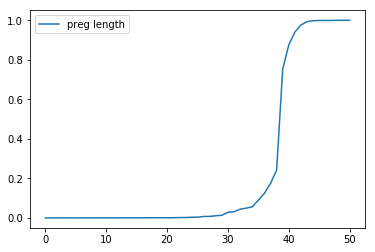

In [13]:
fig,ax=plt.subplots()
x,y = compute_cdf(df,'prglngth')
ax.plot(x,y,label='preg length')
ax.legend()

One way to read a CDF is to look up percentiles.
For example, it looks like about 10% of pregnancies are shorter than 36 weeks,
and about 90% are shorter than 41 weeks. The CDF also provides a visual
representation of the shape of the distribution. Common values appear as
steep or vertical sections of the CDF; in this example, the mode at 39 weeks
is apparent. There are few values below 30 weeks, so the CDF in this range
is flat

Text(0,0.5,'CDF')

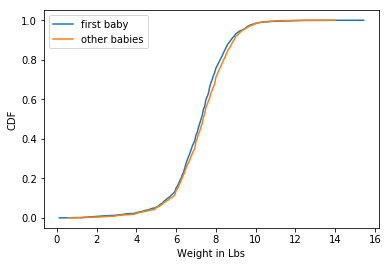

In [14]:
x,y = compute_cdf(df_first_baby,'totalwgt_lb')
x1,y1 = compute_cdf(df_other_babies,'totalwgt_lb')
fig,ax = plt.subplots()
ax.plot(x,y,label='first baby')
ax.plot(x1,y1,label='other babies')
ax.legend()
ax.set_xlabel('Weight in Lbs')
ax.set_ylabel('CDF')

Compared to First Figure (pmf), this figure makes the shape of the distributions, and the differences between them, much clearer.
We can see that first babies are slightly lighter throughout the distribution,
with a larger discrepancy above the mean

Compute the percentile rank
---------------------------
Once you have computed a CDF, it is easy to compute percentiles and percentile ranks. 

The Cdf class provides these two methods:

• PercentileRank(x): Given a value x, computes its percentile rank,
100 · CDF(x).

• Percentile(p): Given a percentile rank p, computes the corresponding value, x. Equivalent to Value(p/100)

In [15]:
def percentile_rank(df,label):
    x = sorted(list(df[label].values))
    y = []
    for value in x:
        y.append(eval_cdf(value,x)*100)
    return x,y

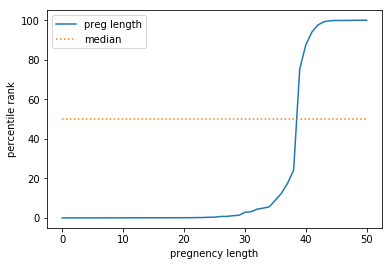

In [16]:
fig,ax=plt.subplots()
x,y = percentile_rank(df,'prglngth')
ax.plot(x,y,label='preg length')
ax.plot([0,50],[50,50],label='median',linestyle=':')
ax.set_xlabel('pregnency length')
ax.set_ylabel('percentile rank')
ax.legend()

Percentile can be used to compute percentile-based summary statistics.
For example, the 50th percentile is the value that divides the distribution in half, also known as the median. Like the mean, the median is a measure of
the central tendency of a distribution.

random numbers
--------------

Suppose we choose a random sample from the population of live births and
look up the percentile rank of their birth weights. Now suppose we compute
the CDF of the percentile ranks

Here’s how we can compute it. First, we make the Cdf of birth weights:

In [17]:
cdf_wgt = compute_cdf(df,'totalwgt_lb')

Then we generate a sample and compute the percentile rank of each value in
the sample:

In [18]:
sample = np.random.choice(df['totalwgt_lb'],100,replace=True)
rank = [eval_cdf(x,sample)*100 for x in sample]

here sample is a random sample of 100 birth weights, chosen with replacement;
that is, the same value could be chosen more than once. ranks is a list of
percentile ranks.

In [19]:
def compute_cdf(series):
    x = sorted(list(series))
    y = []
    for value in x:
        y.append(eval_cdf(value,x))
    return x,y

In [20]:
x,y = compute_cdf(rank)

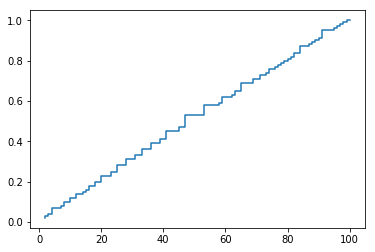

In [21]:
plt.step(x,y)

The CDF is approximately a straight line, which
means that the distribution is uniform.

What this figure shows is that 10% of the sample is below
the 10th percentile, 20% is below the 20th percentile, and so on, exactly as
we should expect.

So, regardless of the shape of the CDF, **the distribution of percentile ranks**
is uniform. This property is useful, because it is the basis of a simple and
efficient algorithm for generating random numbers with a given CDF